# Find Noisy Labels in Regression Datasets

This 5-minute quickstart tutorial uses cleanlab to find potentially incorrect numeric values in a dataset column by means of a regression model. Unlike classification models, regression predicts numeric quantities such as price, income, age,... Response values in regression datasets may be corrupted due to: data entry or measurement errors, noise from sensors or other processes, or broken data pipelines. To find corrupted values in a numeric column, we treat it as the target value, i.e. label, to be predicted by a regression model and then use cleanlab to decide when the model predictions are trustworthy while deviating from the observed label value.

In this tutorial, we consider a student grades dataset, which records three exam grades and some optional notes for over 900 students, each being assigned a final score. Combined with any regression model of your choosing, cleanlab automatically identifies examples in this dataset that have incorrect final scores.

**Overview of what we’ll do in this tutorial:**

- Fit a simple Gradient Boosting model (any other model could be used) on the exam-score and notes (covariates) in order to compute out-of-sample predictions of the final grade (the response variable in our regression).
- Use cleanlab's `CleanLearning.find_label_issues()` method to identify potentially incorrect final grade values based on outputs from this regression model.
- Train a more robust version of the same model after dropping the identified label errors using CleanLearning.
- Run an alternative workflow to detect errors via cleanlab's `Datalab` audit, which can simultaneously estimate **many other types of data issues**.

<div class="alert alert-info">
Quickstart
<br/>
    
Already have an sklearn-compatible regression `model`, features/covariates `X`, and a label/target variable `y`? Run the code below to train your `model` and identify potentially incorrect `y` values in your dataset.


<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab.regression.learn import CleanLearning

cl = CleanLearning(model)
cl.fit(X, y)
label_issues = cl.get_label_issues()
preds = cl.predict(X_test)  # predictions from a version of your model trained on auto-cleaned data
```
    
</div>
    
Is your model/data not compatible with `CleanLearning`? You can instead run cross-validation on your model to get out-of-sample `predictions`. With that, run the code below to find data and label issues in your regression dataset:

<div  class=markdown markdown="1" style="background:white;margin:16px">  
    
```python

from cleanlab import Datalab

# Assuming your dataset has a label column named 'label'
lab = Datalab(dataset, label_name='label', task='regression')
# To detect more data issue types, optionally supply `features` (numeric dataset values or model embeddings of the data)
lab.find_issues(pred_probs=predictions, features=features)

lab.report()
   
```
    
</div>
</div>

## 1. Install required dependencies

You can use `pip` to install all packages required for this tutorial as follows:

```ipython3
!pip install scikit-learn matplotlib>=3.6.0
!pip install cleanlab[datalab]
# Make sure to install the version corresponding to this tutorial
# E.g. if viewing master branch documentation:
#     !pip install git+https://github.com/cleanlab/cleanlab.git
```

In [1]:
# Package installation (hidden on docs website).
# Package versions we used: scikit-learn

dependencies = ["cleanlab", "matplotlib>=3.6.0", "datasets"]

if "google.colab" in str(get_ipython()):  # Check if it's running in Google Colab
    %pip install git+https://github.com/elisno/cleanlab.git@85823cad3e8e530ece51aa04b6f39aa4d61b9d11
    cmd = " ".join([dep for dep in dependencies if dep != "cleanlab"])
    %pip install $cmd
else:
    dependencies_test = [dependency.split('>')[0] if '>' in dependency 
                         else dependency.split('<')[0] if '<' in dependency 
                         else dependency.split('=')[0] for dependency in dependencies]
    missing_dependencies = []
    for dependency in dependencies_test:
        try:
            __import__(dependency)
        except ImportError:
            missing_dependencies.append(dependency)

    if len(missing_dependencies) > 0:
        print("Missing required dependencies:")
        print(*missing_dependencies, sep=", ")
        print("\nPlease install them before running the rest of this notebook.")

In [2]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

from cleanlab.regression.learn import CleanLearning

In [3]:
# This cell is hidden from docs.cleanlab.ai 

import random 
import numpy as np 

SEED = 111 # for reproducibility 

np.random.seed(SEED)
random.seed(SEED)

## 2. Load and process the data

In [4]:
train_data = pd.read_csv("https://s.cleanlab.ai/student_grades_r/train.csv")
test_data = pd.read_csv("https://s.cleanlab.ai/student_grades_r/test.csv")
train_data.head()

exam_1  exam_2  exam_3                           notes  final_score  \
0      72      81      80                             NaN         73.3   
1      89      62      93                             NaN         83.8   
2      97       0      94                             NaN         73.5   
3      80      76      96     missed class frequently -10         78.6   
4      67      87      95  missed homework frequently -10         74.1   

   true_final_score  
0              73.3  
1              83.8  
2              73.5  
3              78.6  
4              74.1

In the DataFrame above, `final_score` represents the noisy scores and `true_final_score` represents the ground truth. Note that ground truth is usually not available in real-world datasets, and is just added in this tutorial dataset for demonstration purposes.

We show a 3D scatter plot of the exam grades, with the color hue corresponding to the final score for each student. Incorrect datapoints are marked with an **X**.

<details><summary>See the code to visualize the data. **(click to expand)**</summary>
    
```ipython3
# Note: This pulldown content is for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
    
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_data(train_data, errors_idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = train_data["exam_1"], train_data["exam_2"], train_data["exam_3"]
    labels = train_data["final_score"]

    img = ax.scatter(x, y, z, c=labels, cmap="jet")
    fig.colorbar(img)

    ax.plot(
        x.iloc[errors_idx],
        y.iloc[errors_idx],
        z.iloc[errors_idx],
        "x",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=2.5,
        alpha=0.8,
        label="Label Errors"
    )
    ax.legend()
```
    
</details>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_data(train_data, errors_idx):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = train_data["exam_1"], train_data["exam_2"], train_data["exam_3"]
    labels = train_data["final_score"]

    img = ax.scatter(x, y, z, c=labels, cmap="jet")
    fig.colorbar(img)

    ax.plot(
        x.iloc[errors_idx],
        y.iloc[errors_idx],
        z.iloc[errors_idx],
        "x",
        markeredgecolor="black",
        markersize=10,
        markeredgewidth=2.5,
        alpha=0.8,
        label="Label Errors"
    )
    ax.legend()

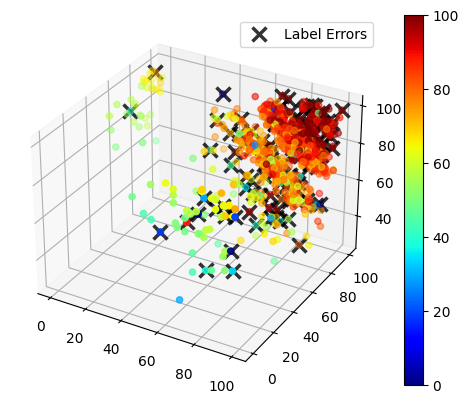

In [6]:
errors_mask = train_data["final_score"] != train_data["true_final_score"]
errors_idx = np.where(errors_mask == 1)

plot_data(train_data, errors_idx)

Next we preprocess the data by applying one-hot encoding to features with categorical data (this is optional if your regression model can work directly with categorical features).

In [7]:
feature_columns = ["exam_1", "exam_2", "exam_3", "notes"]
predicted_column = "final_score"

X_train_raw, y_train = train_data[feature_columns], train_data[predicted_column]
X_test_raw, y_test = test_data[feature_columns], test_data[predicted_column]

In [8]:
categorical_features = ["notes"]
X_train = pd.get_dummies(X_train_raw, columns=categorical_features)
X_test = pd.get_dummies(X_test_raw, columns=categorical_features)

<div class="alert alert-info">
Bringing Your Own Data (BYOD)?

Assign your data's features to variable `X` and the target values to variable `y` instead, then continue with the rest of the tutorial.

</div>

## 3. Define a regression model and use cleanlab to find potential label errors

We'll first demonstrate regression with noisy labels via the `CleanLearning` class that can wrap any scikit-learn compatible regression model you have. `CleanLearning` uses your model to estimate label issues (i.e. noisy `y`-values) and train a more robust version of the same model when the original data contains noisy labels.

Here we define a `CleanLearning` object with a histogram-based gradient boosting model (sklearn version of XGBoost) and use the `find_label_issues` method to find potential errors in our dataset's numeric label column. Any other sklearn-compatible regression model could be used, such as `LinearRegression` or `RandomForestRegressor` (or you can easily wrap arbitrary custom models to be compatible with the sklearn API).

In [9]:
model = HistGradientBoostingRegressor()
cl = CleanLearning(model)

In [10]:
label_issues = cl.find_label_issues(X_train, y_train)

`CleanLearning` internally fits multiple copies of our regression model via cross-validation and bootstrapping in order to compute predictions and uncertainty estimates for the dataset. These are used to identify label issues (i.e. likely corrupted `y`-values).

This method returns a Dataframe containing a label quality score (between 0 and 1) for each example in your dataset. Lower scores indicate examples more likely to be mislabeled with an erroneous `y` value. The Dataframe also contains a boolean column specifying whether or not each example is identified to have a label issue (indicating its `y`-value appears potentially corrupted). 

In [11]:
label_issues.head()

is_label_issue  label_quality  given_label  predicted_label
0           False       0.636197         73.3        76.499503
1           False       0.843478         83.8        82.776647
2            True       0.350358         73.5        63.170547
3           False       0.706969         78.6        75.984759
4           False       0.812515         74.1        75.795928

We can get the subset of examples flagged with label issues, and also sort by label quality score to find the indices of the 10 most likely mislabeled examples in our regression dataset.

In [12]:
identified_issues = label_issues[label_issues["is_label_issue"] == True]
lowest_quality_labels = label_issues["label_quality"].argsort()[:10].to_numpy()

In [13]:
print(
    f"cleanlab found {len(identified_issues)} potential label errors in the dataset.\n"
    f"Here are indices of the top 10 most likely errors: \n {lowest_quality_labels}"
)

cleanlab found 141 potential label errors in the dataset.
Here are indices of the top 10 most likely errors: 
 [659 367  56 318 305 560 657 688 117 160]


Let’s review some of the values most likely to be erroneous. To help us inspect these datapoints, we define a method to print any example from the dataset, together with its given (original) label and the suggested alternative label predicted by your regression model.

In [14]:
def view_datapoint(index):
    given_labels = label_issues["given_label"]
    predicted_labels = label_issues["predicted_label"].round(1)
    return pd.concat(
        [X_train_raw, given_labels, predicted_labels], axis=1
    ).iloc[index]

In [15]:
view_datapoint(lowest_quality_labels[:5])

exam_1  exam_2  exam_3                        notes  given_label  \
659      67      93      93                          NaN         17.4   
367      78       0      86                          NaN          0.0   
56       75      83      69                          NaN          8.9   
318      41      88      98  missed class frequently -10          0.0   
305      97       0      90                          NaN         19.1   

     predicted_label  
659             84.1  
367             56.7  
56              71.7  
318             71.9  
305             61.6

These are very clear errors that cleanlab has identified in this data! Note that the `given_label` does not correctly reflect the final grade that these student should be getting. 

cleanlab has shortlisted the most likely label errors to speed up your data cleaning process. With this list, you can decide whether to fix these label issues or remove erroneous examples from the dataset.

In [16]:
# This cell is hidden from docs.cleanlab.ai 

label_issues_cl = label_issues.copy()

## 4. Train a more robust model from noisy labels

Fixing the label issues manually may be time-consuming, but cleanlab can filter these noisy examples and train a model on the remaining clean data for you automatically.

To establish a baseline, let’s first train and evaluate our original Gradient Boosting model.

In [17]:
baseline_model = HistGradientBoostingRegressor()  
baseline_model.fit(X_train, y_train)

preds_og = baseline_model.predict(X_test)
r2_og = r2_score(y_test, preds_og)
print(f"r-squared score of original model: {r2_og:.3f}")

r-squared score of original model: 0.838


Now that we have a baseline, let’s check if using `CleanLearning` improves our test accuracy.

`CleanLearning` provides a wrapper that can be applied to any scikit-learn compatible model. The resulting model object can be used in the same manner, but it will now train more robustly if the data has noisy labels.

We can use the same `CleanLearning` object defined above, and pass the label issues we already computed into `.fit()` via the `label_issues` argument. This accelerates things; if we did not provide the label issues, then they would be re-estimated via cross-validation. After the issues are estimated, `CleanLearning` simply removes the examples with label issues and retrains your model on the remaining clean data.

In [18]:
found_label_issues = cl.get_label_issues()
cl.fit(X_train, y_train, label_issues=found_label_issues)

preds_cl = cl.predict(X_test)
r2_cl = r2_score(y_test, preds_cl)
print(f"r-squared score of cleanlab's model: {r2_cl:.3f}")

r-squared score of cleanlab's model: 0.926


We can see that the coefficient of determination (r-squared score) of the test set improved as a result of the data cleaning. Note that this will not always be the case, especially when we are evaluating on test data that are themselves noisy. The best practice is to run cleanlab to identify potential label issues and then manually review them, before blindly trusting any evaluation metrics. In particular, the most effort should be made to ensure high-quality test data, which is supposed to reflect the expected performance of our model during deployment.

## 5. Other ways to find noisy labels in regression datasets

The `CleanLearning` workflow above requires a sklearn-compatible model. If your model or data format is not compatible with the requirements for using `CleanLearning`, you can instead run [cross-validation on your regression model to get out-of-sample predictions](https://docs.cleanlab.ai/stable/tutorials/pred_probs_cross_val.html), and then use the `Datalab` audit to estimate label quality scores for each example in your dataset.

This approach requires two inputs:

- `labels`: numpy array of given labels in the dataset. 
- `predictions`: numpy array of predictions for each example in the dataset from your favorite model (these should be out-of-sample predictions to get the best results).

In [19]:
# Get out-of-sample predictions using cross-validation:
model = HistGradientBoostingRegressor()
predictions = cross_val_predict(estimator=model, X=X_train, y=y_train)

In [20]:
from cleanlab import Datalab

lab = Datalab(
    data=train_data.drop(columns=["true_final_score"]),
    label_name="final_score",
    task="regression",
)

lab.find_issues(
    pred_probs=predictions,
    issue_types={"label": {}},  # specify we're only interested in label issues here 
)

Finding label issues ...

Audit complete. 50 issues found in the dataset.


In [21]:
label_issues = lab.get_issues("label")

label_issues.sort_values("label_score").head()

is_label_issue   label_score  given_label  predicted_label
318            True  1.968627e-09          0.0        78.228799
659            True  2.646674e-08         17.4        86.402962
56             True  4.323818e-08          8.9        75.952758
160            True  2.422144e-07          0.0        60.456908
367            True  8.465815e-07          0.0        55.753968

As before, these label quality scores are continuous values in the range [0,1] where 1 represents a clean label (given label appears correct) and 0 a represents dirty label (given label appears corrupted, i.e. the numeric value may be incorrect). You can sort examples by their label quality scores to inspect the most-likely corrupted datapoints.

If possible, we recommend you use `CleanLearning` to wrap your regression model (over providing its pre-computed predictions) for the most accurate label error detection (that properly accounts for aleatoric/epistemic uncertainty in the regression model). To understand how these approaches work, refer to our paper: **[Detecting Errors in Numerical Data via any Regression Model](https://arxiv.org/abs/2305.16583)**

In [22]:
# This cell is hidden from docs.cleanlab.ai
np.random.seed(SEED)  # for reproducibility
random.seed(SEED)

You can alternatively provide `features` to `Datalab` instead of pre-computed predictions. These are (preprocessed) numeric dataset covariates, aka independent variables to the regression model (such as neural network embeddings of your raw data).  Internally, this is equivalent to using `CleanLearning` to find label issues if you also possible provide your sklearn-compatible regression model to `Datalab.find_issues`. But you can simultaneously detect many more types of issues in your dataset beyond mislabeling via Datalab (simply drop the `issue_types` argument below).

In [23]:
lab = Datalab(
    data=train_data.drop(columns=["true_final_score"]),
    label_name="final_score",
    task="regression",
)

lab.find_issues(
    features=X_train,
    issue_types={  # Optional drop this to simultaneously detect many types of data/label issues 
        "label": {
            # Optional: Specify which type of sklearn-compatible regression model is used to find label errors
            "clean_learning_kwargs": {"model": HistGradientBoostingRegressor()}
        }
    },
)

Finding label issues ...



Audit complete. 141 issues found in the dataset.


In [24]:
label_issues = lab.get_issues("label")

label_issues.sort_values("label_score").head()

is_label_issue  label_score  given_label  predicted_label
659            True     0.000005         17.4        84.110719
367            True     0.000044          0.0        56.670640
56             True     0.000060          8.9        71.749976
318            True     0.000066          0.0        71.947007
305            True     0.000314         19.1        61.648396

While this tutorial focused on label issues, cleanlab's `Datalab` object can automatically detect many other types of issues in your dataset (outliers, near duplicates, etc).
Simply remove the `issue_types` argument from the above call to `Datalab.find_issues()` above and `Datalab` will more comprehensively audit your dataset (a default regression model will be used if you don't specify the model type).
Refer to our [Datalab quickstart tutorial](./datalab/datalab_quickstart.html) to learn how to interpret the results (the interpretation remains mostly the same across different types of ML tasks).

**Summary:** To detect many types of issues in your regression dataset, we recommend using `Datalab` with provided `features` plus the best regression model you know for your data. If your goal is to train a robust regression model with noisy data rather than detect data/label issues, then use `CleanLearning`. Alternatively, if you don't have a sklearn-compatible regression model or already have pre-computed predictions from the model you'd like to rely on, you can pass these predictions into `Datalab` directly to find issues based on them instead of providing a regression model.

In [25]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.
from sklearn.metrics import roc_auc_score
from cleanlab.regression.rank import get_label_quality_scores

if r2_cl <= r2_og:
    raise ValueError("CleanLearning did not improve r2 score")

label_quality_score_cl = label_issues_cl["label_quality"]
label_quality_scores_residual = get_label_quality_scores(labels=y_train, predictions=predictions, method="residual")

label_quality_scores = get_label_quality_scores(labels=y_train, predictions=predictions)

auc_outre = roc_auc_score(errors_mask, 1 - label_quality_scores)
auc_cl = roc_auc_score(errors_mask, 1 - label_quality_score_cl)
auc_residual = roc_auc_score(errors_mask, 1 - label_quality_scores_residual)

if auc_outre <= 0.5 or auc_cl <= 0.5:
    raise ValueError("Label quality scores did not perform well enough")

if auc_outre <= auc_residual:
    raise ValueError("Outre label quality scores did not outperform alternative scores")
    
if auc_cl <= auc_residual:
    raise ValueError("CL label quality scores did not outperform alternative scores")

# Test that CleanLearning label issues and Datalab label issues match
pd.testing.assert_frame_equal(
    # CleanLearning DataFrame
    label_issues_cl.rename(columns={"label_quality": "label_score"}), 
    # Datalab DataFrame
    label_issues,
)